In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [56]:
'''
Purpose: This class represents a single module in the song bird system, aka HVC or RA
- can be though of a single layer, with a set of neurons that are designated as the input, and a set of neurons that are designated as the output, you can technically even set only to have input neurons if you want 
'''

class SpikingModule():
    def __init__(self, inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range):
        self.total_neurons = inter_neuron_count + input_count + output_count
        self.neuron_states = np.random.uniform(0, 1, (self.total_neurons))
        self.connectivity_matrix = np.random.uniform(-1, 1, (self.total_neurons, self.total_neurons, 2))
        self.input_matrix = np.random.uniform(-1, 1, (input_count))
        self.inter_neuron_count = inter_neuron_count
        
        self.clock = 0
        self.firing_history = []
        self.input_firing_history = []
        self.output_firing_history = []
        self.decay_rate = decay_rate
        self.learning_rate = learning_rate
        self.time_constant = time_constant
        self.threshold = threshold

        self.input_freeze_mask = np.zeros_like(self.input_matrix, dtype=bool)
        self.intra_freeze_mask = np.zeros((self.total_neurons, self.total_neurons), dtype=bool)
        
        self.input_count = input_count
        self.output_count = output_count
        
        self.initialize_bias(initial_bias_range)
        self.last_spike_time = np.zeros(self.total_neurons, dtype=int) - 1
    
    def initialize_bias(self, initial_bias_range):
        self.bias_matrix = np.random.uniform(-initial_bias_range, initial_bias_range, (self.total_neurons, self.total_neurons, 2))

    def stdp(self):
        # Compute time since last spike for all neurons
        time_since_last_spike = self.clock - self.last_spike_time

        # Update weights based on STDP rule
        for i in range(len(self.connectivity_matrix)):
            for j in range(len(self.connectivity_matrix[i])):
                if i == j or self.intra_freeze_mask[i, j]:
                    continue
                last_spike_i = self._find_last_spike(i)
                last_spike_j = self._find_last_spike(j)
                if last_spike_i is None or last_spike_j is None:
                    continue
                delta_t = time_since_last_spike[last_spike_i] - time_since_last_spike[last_spike_j]
                weight_update = self.learning_rate * self.stdp_rule(delta_t)
                self.connectivity_matrix[i, j, 0] += weight_update
                self.connectivity_matrix[j, i, 1] -= weight_update

    def stdp_rule(self, delta_t):
        tau = 20  # Time constant for the exponential decay
        positive_delta_t = delta_t > 0
        result = np.zeros_like(delta_t)
        result[positive_delta_t] = np.exp(-delta_t[positive_delta_t] / tau)
        result[~positive_delta_t] = -np.exp(delta_t[~positive_delta_t] / tau)
        return result

    def _find_last_spike(self, neuron_index):
        last_spike = None
        for time_step, fired_neurons in enumerate(reversed(self.firing_history)):
            if np.isin(neuron_index, fired_neurons):
                last_spike = neuron_index
                break
        return last_spike

    def step(self, input):
        prev_state = self.neuron_states

        # process input
        weighted_input = np.dot(self.input_matrix, input)
        self.neuron_states[:len(input)] += weighted_input

        forward_updated = np.dot(prev_state, self.connectivity_matrix[:, :, 0])
        forward_updated = forward_updated + np.diag(self.bias_matrix[:, :, 0])

        backward_updated = np.dot(self.connectivity_matrix[:, :, 1], prev_state)
        backward_updated = backward_updated + np.diag(self.bias_matrix[:, :, 1])

        # take the forward and backward updated values and add them together 
        combined_updated = forward_updated + backward_updated

        # add them to the previous neuronal state
        updated_state = prev_state + combined_updated

        # multiply by the decay rate
        self.neuron_states = updated_state * self.decay_rate

        # find the neurons that have fired
        fired_neurons = np.where(self.neuron_states > self.threshold)

        # update the firing history
        self.firing_history.append(fired_neurons)

        # reset the neuron states of the fired neurons to 0
        self.neuron_states[fired_neurons] = 0

        # update last_spike_time for fired neurons
        self.last_spike_time[fired_neurons] = self.clock

        # compute the output spikes
        output_spikes = self.neuron_states[-self.output_count:]

        # update the output firing history
        self.output_firing_history.append(output_spikes)

        # update the weights
        self.stdp()

        # increment the clock
        self.clock += 1

    def set_input_weights(self, input_weights):
        self.input_matrix = np.array(input_weights)

    def set_internal_weights(self, internal_weights):
        self.connectivity_matrix = np.array(internal_weights)

    def get_output(self):
        output = self.output_weights.T.dot(self.neuron_states)
        return output

    def set_input_weights(self, input_weights):
        self.input_matrix = input_weights

    def set_internal_weights(self, internal_weights):
        self.internal_connectivity_matrix = internal_weights

    def set_output_weights(self, output_weights):
        self.output_weights = output_weights

    def visualize_firing_history(self):
        # Create a figure for the firing history
        plt.figure(figsize=(10, 5))

        # Plot neuron firing history
        for i, fired_neurons in enumerate(self.firing_history):
            for neuron_idx in fired_neurons[0]:
                if neuron_idx < self.input_count:
                    color = 'gold'
                elif neuron_idx < self.input_count + self.inter_neuron_count:
                    color = 'skyblue'
                else:
                    color = 'limegreen'

                plt.plot(i, neuron_idx, marker='o', markersize=5, linestyle='None', color=color)

        plt.xlabel('Time Step')
        plt.ylabel('Neuron Index')
        plt.title('Firing History')

        # Set y-tick labels to integers
        y_ticks = np.arange(0, self.total_neurons, 1)
        plt.yticks(y_ticks)

        plt.show()

    def visualize_directed_graph(self):
        # Create a directed graph
        G = nx.DiGraph()

        # Add input, neuron, and output nodes
        input_nodes = range(self.input_count)
        inter_nodes = range(self.input_count, self.input_count + self.inter_neuron_count)
        output_nodes = range(self.input_count + self.inter_neuron_count, self.total_neurons)

        for node in input_nodes:
            G.add_node(node, node_type='input')
        for node in inter_nodes:
            G.add_node(node, node_type='inter')
        for node in output_nodes:
            G.add_node(node, node_type='output')

        # Add edges based on input, internal, and output connectivity matrices
        for i in range(self.total_neurons):
            for j in range(self.total_neurons):
                if i == j:
                    continue
                weight = self.connectivity_matrix[i, j, 0] - self.connectivity_matrix[j, i, 1]
                G.add_edge(i, j, weight=weight)

        # Position input nodes on the left, output nodes on the right, and inter-neuron nodes in between
        pos = {}
        for node in input_nodes:
            pos[node] = (0, (node / len(input_nodes)) * 2 - 1)
        for node in inter_nodes:
            pos[node] = (0.5, (node - len(input_nodes)) / len(inter_nodes) * 2 - 1)
        for node in output_nodes:
            pos[node] = (1, (node - self.input_count - self.inter_neuron_count) / len(output_nodes) * 2 - 1)

        # Plot the network
        fig, ax = plt.subplots()

        # Draw input, inter-neuron, and output nodes with different colors
        input_colors = ['gold'] * len(input_nodes)
        inter_colors = ['skyblue'] * len(inter_nodes)
        output_colors = ['limegreen'] * len(output_nodes)

        nx.draw_networkx_nodes(G, pos, nodelist=input_nodes, node_size=1000, node_color=input_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=inter_nodes, node_size=1000, node_color=inter_colors, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=output_nodes, node_size=1000, node_color=output_colors, ax=ax)

        # Draw edges with varying thickness based on weights and different colors for inhibitory and excitatory connections
        for (u, v, d) in G.edges(data=True):
            weight = d['weight']
            edge_color = "red" if weight < 0 else "black"
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=abs(weight) * 5, edge_color=edge_color, ax=ax)

        # Draw node labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)

        plt.show()


    def freeze_weights(self, selected_neurons, percent_to_freeze, neurons=None):
        """
        Purpose:
        - Freeze the specified percentage of weights for the selected neurons or specific neurons.
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to freeze.
        - percent_to_freeze (float): The percentage of weights to freeze (between 0 and 1).
        - neurons (list of int, optional): The indices of specific neurons to freeze. If not provided, weights are frozen randomly.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not 0 <= percent_to_freeze <= 1:
            raise ValueError("percent_to_freeze must be between 0 and 1.")

        # Choose the weight matrix based on selected_neurons
        if selected_neurons == 'input':
            weight_matrix = self.input_matrix
        elif selected_neurons == 'intra':
            weight_matrix = self.internal_connectivity_matrix
        else:
            weight_matrix = self.output_weights

        # Create a mask to indicate frozen weights
        freeze_mask = np.zeros_like(weight_matrix, dtype=bool)

        if neurons is not None:
            if not all(isinstance(n, int) for n in neurons):
                raise ValueError("neurons must be a list of integers.")

            # Freeze all weights for the specified neurons
            for neuron_index in neurons:
                if selected_neurons == 'input':
                    freeze_mask[:, neuron_index] = True
                elif selected_neurons == 'intra':
                    freeze_mask[neuron_index, :] = True
                    freeze_mask[:, neuron_index] = True
                else:
                    freeze_mask[neuron_index, :] = True
        else:
            # Calculate the number of weights to freeze
            num_weights_to_freeze = int(np.prod(weight_matrix.shape) * percent_to_freeze)

            # Choose the indices of the weights to freeze
            freeze_indices = np.random.choice(np.arange(weight_matrix.size), num_weights_to_freeze, replace=False)
            freeze_mask.ravel()[freeze_indices] = True

        # Assign the freeze_mask to the corresponding attribute
        if selected_neurons == 'input':
            self.input_freeze_mask = freeze_mask
        elif selected_neurons == 'intra':
            self.intra_freeze_mask = freeze_mask
        else:
            self.output_freeze_mask = freeze_mask

    def remove_connection(self, selected_neurons, neuron_indices):
        """
        Purpose:
        - Set a certain weight to zero and freeze it permanently (remove the connection).
        Args:
        - selected_neurons (str): 'input', 'intra', or 'output' to choose which weights to remove.
        - neuron_indices (tuple): A tuple containing two indices (i, j) representing the weight to remove.
        """

        if selected_neurons not in ('input', 'intra', 'output'):
            raise ValueError("selected_neurons must be one of 'input', 'intra', or 'output'.")

        if not isinstance(neuron_indices, tuple) or len(neuron_indices) != 2 or not all(isinstance(n, int) for n in neuron_indices):
            raise ValueError("neuron_indices must be a tuple of two integers.")

        i, j = neuron_indices

        # Remove the connection and freeze the weight
        if selected_neurons == 'input':
            self.input_matrix[i, j] = 0
            self.input_freeze_mask[i, j] = True
        elif selected_neurons == 'intra':
            self.internal_connectivity_matrix[i, j] = 0
            self.intra_freeze_mask[i, j] = True
        else:
            self.output_weights[i, j] = 0
            self.output_freeze_mask[i, j] = True

    def no_input_step(self):
        """
        Purpose:
        - Perform a single time step of the network without any input.
        """

        self.step(np.zeros(self.input_matrix.shape[0]))

### Testing the SpikingModule Class

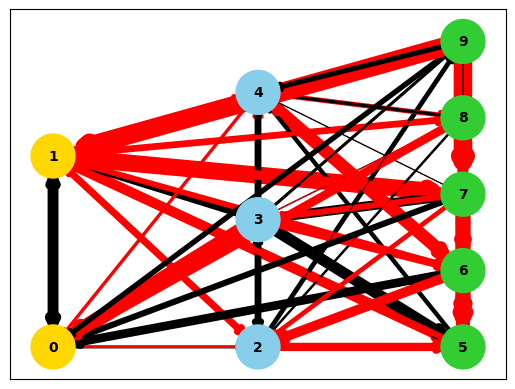

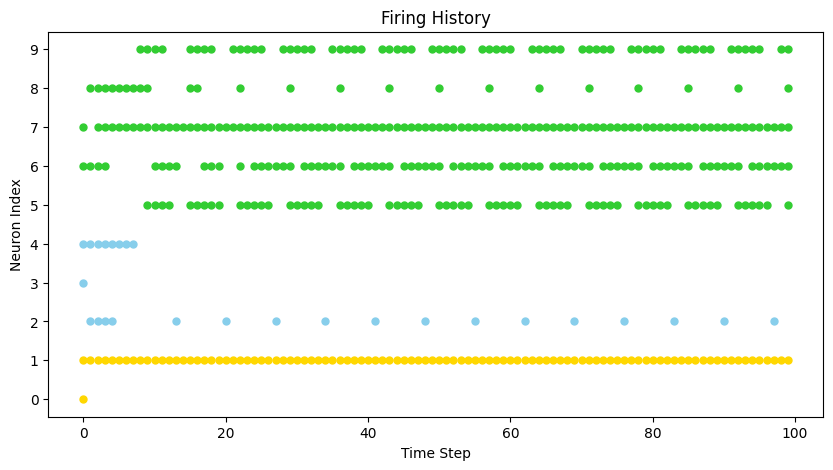

In [57]:
input_count = 2
inter_neuron_count = 3
output_count = 5

decay_rate = 0.9
threshold = 1
learning_rate = 0.01
time_constant = 20
inital_sparsity = 0.1
initial_bias_range = 0.1

module.visualize_directed_graph()

module = SpikingModule(inter_neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant, inital_sparsity, initial_bias_range)

for i in range(100):
    input = np.random.randint(0, 10, input_count)
    module.step(input)

module.visualize_directed_graph()
module.visualize_firing_history()

### Testing the HVC Ability to Learn a Song Sequence

In [ ]:
HVC = SpikingModule(neuron_count=4, input_count=2, output_count=2, decay_rate=0.5, threshold=2, learning_rate=0.01, time_constant=38)

cycle_count = 100
cycle = 0

# create a one to one mapping of the first 5 inputs to the first 5 neurons
# Get the number of neurons and inputs
num_neurons = module.internal_connectivity_matrix.shape[0]
num_inputs = module.input_matrix.shape[0]

# Loop through all the connections
for input_idx in range(num_inputs):
    for neuron_idx in range(num_neurons):
        # Skip the one-to-one mappings for the first 5 neurons and inputs
        if input_idx == neuron_idx and input_idx < 5:
            continue
        module.remove_connection('input', (input_idx, neuron_idx))

HVC.visualize_network()

# while cycle < cycle_count:
#     input = [2,0,0,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,2,0,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,2,0,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,0,2,0]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle+=10
#     input = [0,0,0,0,2]
#     HVC.step(input)
#     for i in range(10):
#         HVC.no_input_step()
#     cycle += 10

#     for i in range(100):
#         HVC.no_input_step()
#     cycle += 100
    
# HVC.visualize_network()

neuron states:  [0.21214695 0.37625184 0.57479824 0.22833855 0.76758453 0.19728809
 0.14686661 0.88376809 0.10646536]
neuron states:  [ 0.9         0.9        -0.33602448 -1.25316773 -1.45510745 -1.17442478
 -0.56088643 -3.1934216  -1.28488005]
neuron states:  [ 0.9         0.9        -0.34311985 -0.14387039  0.         -1.57485109
  0.29901395  0.09241729  0.03805273]
neuron states:  [ 0.9         0.9         0.07209216 -1.22241158 -0.65844602 -2.88307867
 -1.22205718 -3.29708754 -1.51141181]
neuron states:  [ 0.9         0.          0.         -1.95068328  0.         -2.16420215
  0.43046903 -0.55130718  1.90113393]
neuron states:  [ 0.9         0.9        -0.70936212 -1.43359653  0.15469606 -2.85056408
  0.24298145 -2.91712295 -0.84524615]
neuron states:  [ 0.          0.9        -0.26643794 -1.26980249  0.         -3.4418418
 -0.43567243 -2.53644359 -0.96264434]
neuron states:  [ 0.9         0.9         0.         -2.43391185  0.16245914 -4.03281729
 -0.53502156 -3.36240032 -0.1650

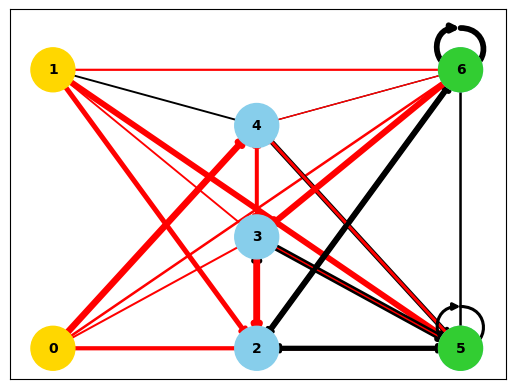

In [51]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming SpikingModule class is defined with all the changes

# Create a new instance of the SpikingModule
neuron_count = 5
input_count = 2
output_count = 2
decay_rate = 0.9
threshold = 0.5
learning_rate = 0.01
time_constant = 10
module = SpikingModule(neuron_count, input_count, output_count, decay_rate, threshold, learning_rate, time_constant)

# Run the SpikingModule for several steps
for _ in range(10):
    input = np.random.randint(0, 10, input_count)
    module.step(input)

# Visualize the directed graph
module.visualize_directed_graph()
plt.show()
